In [3]:
import pickle

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import seaborn as sns

from core.src.constants import IMAGES_PATH, TRAIN_DATA_CSV, TEST_DATA_CSV, FINE_TUNED_FASTVIT_MODEL_PATH, TARGET_SCALER_PATH
from PIL import Image
import timm
from torch import nn
import pandas as pd

from core.src.utils.metrics import compute_metrics
from core.src.utils.plots import plot_loss_and_metrics, print_metrics_table

with open(TARGET_SCALER_PATH, "rb") as f:
    target_scaler = pickle.load(f)

model = timm.create_model("fastvit_t8.apple_in1k", pretrained=True, num_classes=0)

model.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(model.num_features, 1))

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=True)

model

FastVit(
  (stem): Sequential(
    (0): MobileOneBlock(
      (se): Identity()
      (conv_kxk): ModuleList(
        (0): ConvNormAct(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
        )
      )
      (conv_scale): ConvNormAct(
        (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act): GELU(approximate='none')
    )
    (1): MobileOneBlock(
      (se): Identity()
      (conv_kxk): ModuleList(
        (0): ConvNormAct(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=48, bias=False)
          (bn): Batch

In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, prices, transform=None):
        self.image_paths = image_paths
        self.prices = prices
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        price = self.prices[idx]
        if self.transform:
            img = self.transform(img)
        return img, price


SLICE: int | None = None

df_train = pd.read_csv(TRAIN_DATA_CSV, dtype={"unique_id": str})[:SLICE]
df_test = pd.read_csv(TEST_DATA_CSV, dtype={"unique_id": str})[:SLICE]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_images = df_train["unique_id"].values
train_images = [IMAGES_PATH / f"{path}.png" for path in train_images]

test_images = df_test["unique_id"].values
test_images = [IMAGES_PATH / f"{path}.png" for path in test_images]

train_dataset = CustomDataset(
    image_paths=train_images,
    prices=df_train["price_std"].values,
    transform=transforms,
)

test_dataset = CustomDataset(
    image_paths=test_images,
    prices=df_test["price_std"].values,
    transform=transforms,
)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

num_epochs = 10  # or more depending on convergence

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    all_train_predictions = []
    all_train_ground_truths = []
    for images, prices in tqdm(train_loader):
        images = images.to(device)
        prices = prices.to(device)

        # Forward pass
        outputs = model(images).squeeze()  # Squeeze is used to remove extra dim if any at output
        loss = criterion(outputs, prices.float())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)
        unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)

        all_train_predictions.extend(unnorm_outputs.tolist())
        all_train_ground_truths.extend(unnorm_prices.tolist())

    train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
    metrics_history["train_mae"].append(train_metrics["MAE"])
    metrics_history["train_mse"].append(train_metrics["MSE"])
    metrics_history["train_rmse"].append(train_metrics["RMSE"])
    metrics_history["train_r2"].append(train_metrics["R2"])

    avg_train_loss = np.sum(train_losses) / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")
    print(f"Epoch {epoch + 1}, Train Metrics: {train_metrics}")

    model.eval()
    with torch.no_grad():
        validation_losses = []
        all_test_predictions = []
        all_test_ground_truths = []
        for images, prices in test_loader:
            images = images.to(device)
            prices = prices.to(device)

            # Forward pass
            outputs = model(images).squeeze()  # Squeeze is used to remove extra dim if any at output
            val_loss = criterion(outputs, prices.float())

            validation_losses.append(val_loss.item())

            unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)
            unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)

            all_test_predictions.extend(unnorm_outputs.tolist())
            all_test_ground_truths.extend(unnorm_prices.tolist())

        avg_val_loss = np.sum(validation_losses) / len(test_loader)
        history["test_loss"].append(avg_val_loss)

        test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
        metrics_history["test_mae"].append(test_metrics["MAE"])
        metrics_history["test_mse"].append(test_metrics["MSE"])
        metrics_history["test_rmse"].append(test_metrics["RMSE"])
        metrics_history["test_r2"].append(test_metrics["R2"])

        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
        print(f"Epoch {epoch + 1}, Test Metrics: {test_metrics}")

100%|██████████| 810/810 [05:02<00:00,  2.68it/s]


Epoch 1, Train Loss: 0.730645135320999
Epoch 1, Train Metrics: {'MAE': 5892.500445625972, 'MSE': 58164442.511469744, 'RMSE': 7626.561644113928, 'R2': 0.26582975189593216}
Epoch 1, Validation Loss: 0.6679454307838026
Epoch 1, Test Metrics: {'MAE': 5364.253820637227, 'MSE': 53231913.20474098, 'RMSE': 7296.020367621035, 'R2': 0.3294254368957742}


100%|██████████| 810/810 [04:45<00:00,  2.83it/s]


Epoch 2, Train Loss: 0.5861753662979161
Epoch 2, Train Metrics: {'MAE': 5167.74015993259, 'MSE': 46655716.12718151, 'RMSE': 6830.498966194308, 'R2': 0.41109658744152444}
Epoch 2, Validation Loss: 0.5507498637502417
Epoch 2, Test Metrics: {'MAE': 5138.966869632826, 'MSE': 43889541.96476471, 'RMSE': 6624.91826098743, 'R2': 0.4471134202021232}


100%|██████████| 810/810 [05:00<00:00,  2.70it/s]


Epoch 3, Train Loss: 0.5299875683806561
Epoch 3, Train Metrics: {'MAE': 4850.186780484169, 'MSE': 42181978.328633904, 'RMSE': 6494.76545601409, 'R2': 0.46756554076923085}
Epoch 3, Validation Loss: 0.49050354113426115
Epoch 3, Test Metrics: {'MAE': 4695.060656883401, 'MSE': 39113384.81636752, 'RMSE': 6254.069460468721, 'R2': 0.5072797621629137}


100%|██████████| 810/810 [04:39<00:00,  2.90it/s]


Epoch 4, Train Loss: 0.5016450206990595
Epoch 4, Train Metrics: {'MAE': 4721.6964986894955, 'MSE': 39924544.32787473, 'RMSE': 6318.587209802103, 'R2': 0.496059596739751}
Epoch 4, Validation Loss: 0.5114811882009647
Epoch 4, Test Metrics: {'MAE': 4629.116516424252, 'MSE': 40751652.53929806, 'RMSE': 6383.702102957034, 'R2': 0.4866421296523832}


100%|██████████| 810/810 [04:35<00:00,  2.94it/s]


Epoch 5, Train Loss: 0.48061417433214776
Epoch 5, Train Metrics: {'MAE': 4597.456959633565, 'MSE': 38228889.340577655, 'RMSE': 6182.951507215438, 'R2': 0.517462697826421}
Epoch 5, Validation Loss: 0.45274961890258225
Epoch 5, Test Metrics: {'MAE': 4413.505033906787, 'MSE': 36080068.394554324, 'RMSE': 6006.668660293684, 'R2': 0.5454911416128843}


100%|██████████| 810/810 [04:35<00:00,  2.94it/s]


Epoch 6, Train Loss: 0.45567221701329136
Epoch 6, Train Metrics: {'MAE': 4451.046262304013, 'MSE': 36268442.54085167, 'RMSE': 6022.328664300187, 'R2': 0.5422080860946198}
Epoch 6, Validation Loss: 0.4648332576739964
Epoch 6, Test Metrics: {'MAE': 4644.646835395468, 'MSE': 37055972.06318259, 'RMSE': 6087.361666862138, 'R2': 0.5331974603073637}


100%|██████████| 810/810 [04:35<00:00,  2.94it/s]


Epoch 7, Train Loss: 0.4483495291184496
Epoch 7, Train Metrics: {'MAE': 4402.711105475388, 'MSE': 35688855.9902352, 'RMSE': 5974.015064446624, 'R2': 0.5495238134237344}
Epoch 7, Validation Loss: 0.44729767684719246
Epoch 7, Test Metrics: {'MAE': 4402.9537602857945, 'MSE': 35682532.386278756, 'RMSE': 5973.485781876338, 'R2': 0.5504989934637519}


100%|██████████| 810/810 [04:53<00:00,  2.76it/s]


Epoch 8, Train Loss: 0.4259716263247861
Epoch 8, Train Metrics: {'MAE': 4287.00579681258, 'MSE': 33863037.819900975, 'RMSE': 5819.195633410254, 'R2': 0.5725698759531374}
Epoch 8, Validation Loss: 0.4490473370246699
Epoch 8, Test Metrics: {'MAE': 4341.975068483857, 'MSE': 35792568.497480735, 'RMSE': 5982.689069095998, 'R2': 0.5491128434504854}


100%|██████████| 810/810 [04:43<00:00,  2.86it/s]


Epoch 9, Train Loss: 0.41196749407200167
Epoch 9, Train Metrics: {'MAE': 4203.489619234743, 'MSE': 32788901.28968533, 'RMSE': 5726.159383887714, 'R2': 0.5861279717387293}
Epoch 9, Validation Loss: 0.4684349190939236
Epoch 9, Test Metrics: {'MAE': 4273.217586864232, 'MSE': 37338654.27801659, 'RMSE': 6110.536333090295, 'R2': 0.5296364479127772}


100%|██████████| 810/810 [04:36<00:00,  2.93it/s]


Epoch 10, Train Loss: 0.3974129440791813
Epoch 10, Train Metrics: {'MAE': 4105.321360966834, 'MSE': 31641738.113201093, 'RMSE': 5625.098942525464, 'R2': 0.600607833274911}
Epoch 10, Validation Loss: 0.41353741611165956
Epoch 10, Test Metrics: {'MAE': 4245.6826020347235, 'MSE': 32953832.672733713, 'RMSE': 5740.542890070043, 'R2': 0.5848730466978582}


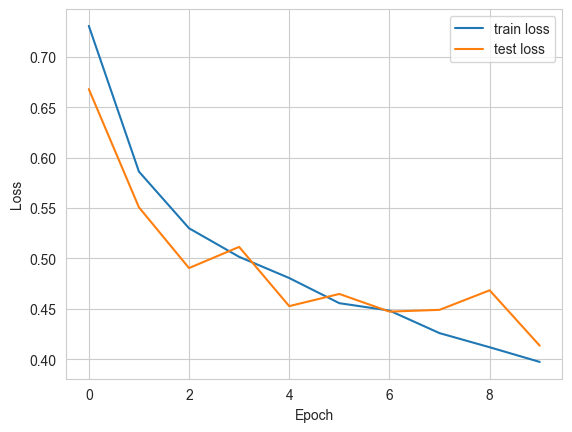

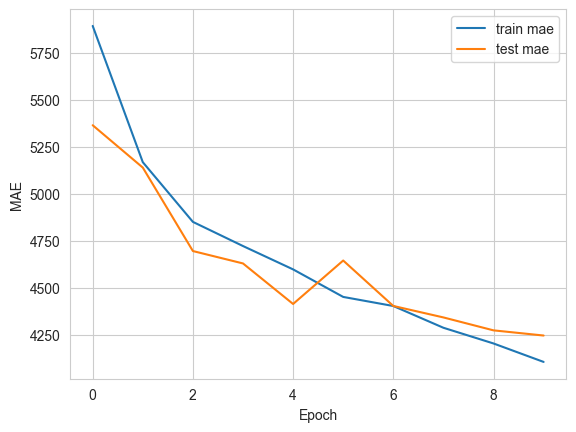

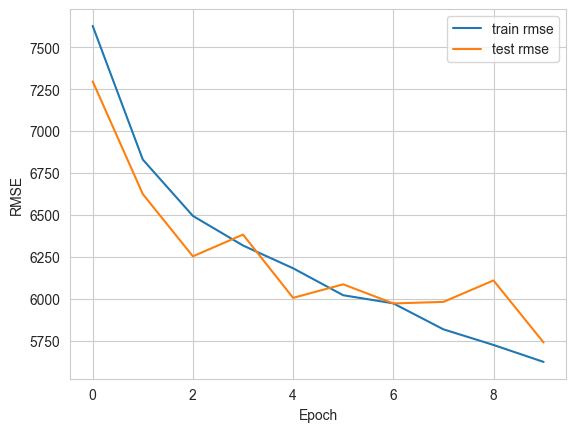

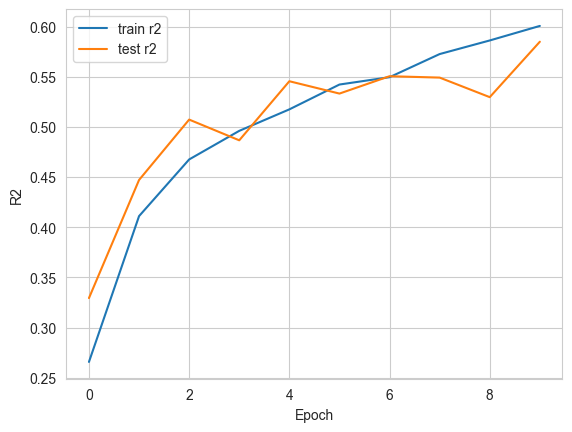

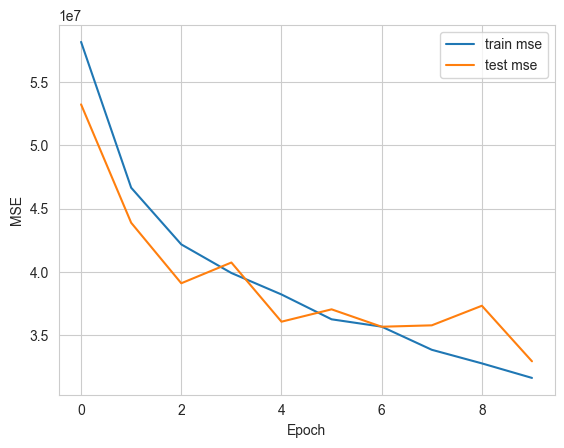

Train Metrics
+---------+---------+--------+---------+-------------+
|   Epoch |     MAE |   RMSE |      R2 |         MSE |
+=========+=========+========+=========+=============+
|       9 | 4105.32 | 5625.1 | 0.60061 | 3.16417e+07 |
+---------+---------+--------+---------+-------------+

Test Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|       9 | 4245.68 | 5740.54 | 0.58487 | 3.29538e+07 |
+---------+---------+---------+---------+-------------+


In [7]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=0)
print_metrics_table(metrics_history)

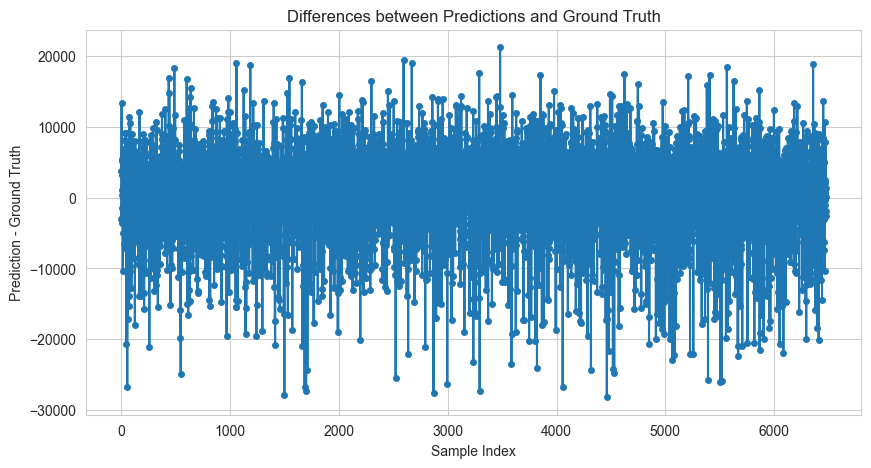

Average absolute difference: 4345.30


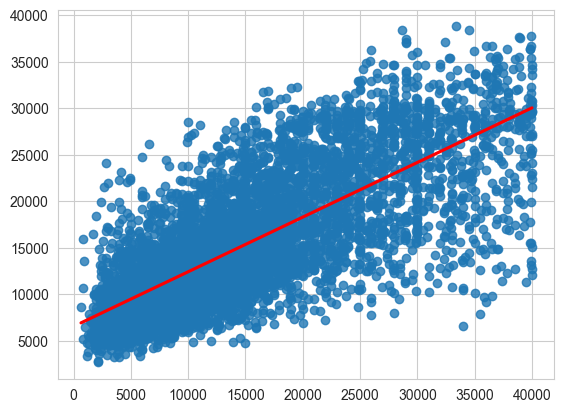

In [12]:
differences = []
abs_differences = []
gt = []
pred = []

with torch.no_grad():
    for images, prices in test_loader:
        images = images.to(device)
        prices = prices.to(device)
        outputs = model(images).squeeze()

        prices = prices.cpu().numpy()
        outputs = outputs.cpu().numpy()

        unnorm_outputs = target_scaler.inverse_transform(outputs.reshape(-1, 1)).reshape(-1)
        unnorm_prices = target_scaler.inverse_transform(prices.reshape(-1, 1)).reshape(-1)

        for output, target in zip(unnorm_outputs, unnorm_prices):
            diff = output - target
            differences.append(diff)
            abs_differences.append(abs(diff))
            gt.append(target)
            pred.append(output)

# Plotting the differences
plt.figure(figsize=(10, 5))
plt.plot(differences, marker="o", linestyle="-", markersize=4)
plt.title("Differences between Predictions and Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("Prediction - Ground Truth")
plt.grid(True)
plt.show()

sns.regplot(x=gt, y=pred, ci=None, scatter=True, line_kws={"color": "red"})

# calculate the average difference
average_abs_diff = sum(abs_differences) / len(abs_differences)
print(f"Average absolute difference: {average_abs_diff:.2f}")

In [13]:
torch.save(model.state_dict(), f=FINE_TUNED_FASTVIT_MODEL_PATH)

# Inference example

In [ ]:
# model = timm.create_model("fastvit_t8.apple_in1k", pretrained=True, num_classes=0)
#
# model.head = nn.Sequential(
#     nn.AdaptiveAvgPool2d(1),
#     nn.Flatten(),
#     nn.Linear(model.num_features, 1)
# )
#
# model.load_state_dict(torch.load(FINE_TUNED_FASTVIT_MODEL_PATH))
# model.to(device)
#
# model
#
#
# class FastViTEmbedding(nn.Module):
#     def __init__(self, model):
#         super(FastViTEmbedding, self).__init__()
#         self.model = model
#         self.pool = nn.AdaptiveAvgPool2d(1)
#
#     def forward(self, x):
#         # Assuming the embeddings you want are just before the head.
#         # This accesses the last layer before the regression head.
#         x = self.model.forward_features(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         return x
#
#
# embedding_model = FastViTEmbedding(model).to(device)
# embedding_model.eval()
#
# with torch.no_grad():
#     for images, _ in test_loader:  # Ignore prices if you just need embeddings
#         images = images.to(device)
#         embeddings = embedding_model(images)
#         print("Embedding shape:", embeddings.shape)